# PLS-DA additional models

As before, switch to the right kernel by clicking on the button in the top 
right corner with "Python 3 (ipykernel)" and switch to "omics_predoc_course".

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score


sns.set_theme()


def separate(data, col, into, sep="_", **kwargs):
    return data.assign(
        **data.get(col).str.split(sep, expand=True, **kwargs)
        .rename(columns={i: x for i, x in enumerate(into)})
    )

## Load the data

As in the previous notebook, we first load the normalised counts from DESeq2 analysis:

In [2]:
df_norm = pd.read_csv("../Output/DESeq2/normalised_counts.csv", index_col=0)

and load the MIC values and we create additional columns for level of 
antibiotic resistence for both antibiotics (0 for low ABR and 1 for high ABR):

In [3]:
mic_threshold = 30
df_mic = (
    pd.read_csv("../Data/mic.csv", dtype={"strain": str})
    .assign(
        cza_mic_level=lambda x: (x.cza_mic > mic_threshold).astype(int),
        mem_mic_level=lambda x: (x.mem_mic > mic_threshold).astype(int)
    )
)

## Leave-one-out models

To test the generalizability of the models, we performed a leave-one-strain-out analysis, 
where each of the models was trained on the data from six strains (45 samples) and tested 
on the data from the sixth strain not included in the training (9 samples).

First, we transform the dataframe to the correcto format:

In [4]:
df_norm_rot = (
    df_norm
    .transpose()
    .reset_index(names="sample")
    .pipe(separate, "sample", ["strain", "condition", "replicate"], sep="_")
    .merge(df_mic, on=["strain", "condition"], how="left")
)
df_norm_rot.head()

,sample,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,...,PA5568,PA5569,PA5570,strain,condition,replicate,cza_mic,mem_mic,cza_mic_level,mem_mic_level
0,083.2_C_A,5220.732964,6296.697977,6468.349983,16989.361962,588.919891,271.433457,151.416607,2340.328570,2359.168424,...,8388.619579,7076.109728,1159.697699,083.2,C,A,256.0,48.0,1,1
1,083.2_C_B,5995.205109,7725.134664,8212.623565,21378.861047,592.455454,289.667318,131.208193,2420.286507,2457.630377,...,10018.250154,7662.558449,629.799325,083.2,C,B,256.0,48.0,1,1
2,083.2_C_C,9486.768364,11275.401217,12061.581343,29299.092068,628.359581,244.037325,135.901026,2829.079414,3368.299612,...,14877.509045,9345.022133,416.470885,083.2,C,C,256.0,48.0,1,1
3,083.2_M_A,7606.620910,8759.406768,11216.328926,24165.620400,839.994947,292.610852,134.954143,2504.849797,2975.297418,...,11661.551473,9078.503948,567.564153,083.2,M,A,48.0,256.0,1,1
4,083.2_M_B,6496.149593,8039.748776,10054.776996,22424.952765,813.546007,281.024653,123.202837,2218.669273,2824.501406,...,12805.967623,9338.978694,584.449822,083.2,M,B,48.0,256.0,1,1


As in the previous notebook, we fit the models to the data, but this time we leave data related to one strain per each model

In [5]:
strains = ["083.2", "090.3", "095.3", "678.3", "804.2", "816.3"]
meta_cols = ["sample", "strain", "condition", "replicate", "cza_mic", "mem_mic", "cza_mic_level", "mem_mic_level"]
models = {strain: PLSRegression(n_components=2) for strain in strains}

factors = {}

for strain, model in models.items():
    train_data = df_norm_rot.query("strain != @strain")
    x_train = train_data.drop(columns=meta_cols).to_numpy()
    y_train = train_data.mem_mic_level.to_numpy()
    model.fit(x_train, y_train)

    factors[strain] = model.transform(x_train, y_train)

We can combine all the factor values from each model in one dataframe:

In [6]:
df_pls = pd.concat([
    pd.DataFrame(factor_vals[0], columns=["Factor1", "Factor2"])
    .join(
        df_norm_rot
        .query("strain != @strain")
        .get(meta_cols)
        .reset_index(drop=True)
    ).assign(strain_left=strain)
    for strain, factor_vals in factors.items()
], ignore_index=True)
df_pls

,Factor1,Factor2,sample,strain,condition,replicate,cza_mic,mem_mic,cza_mic_level,mem_mic_level,strain_left
0,-7.089587,-1.430337,090.3_C_A,090.3,C,A,256.0,6.0,1,0,083.2
1,-37.799794,24.353618,090.3_C_C,090.3,C,C,256.0,6.0,1,0,083.2
2,-25.355659,14.606184,090.3_C_D,090.3,C,D,256.0,6.0,1,0,083.2
3,34.492475,19.832531,090.3_M_B,090.3,M,B,8.0,192.0,0,1,083.2
4,26.395550,28.786942,090.3_M_C,090.3,M,C,8.0,192.0,0,1,083.2
...,...,...,...,...,...,...,...,...,...,...,...
265,-0.123184,0.977549,804.2_M_C,804.2,M,C,4.0,192.0,0,1,816.3
266,-1.532697,-6.751107,804.2_M_D,804.2,M,D,4.0,192.0,0,1,816.3
267,0.279107,13.568054,804.2_P_A,804.2,P,A,3.0,6.0,0,0,816.3
268,-4.996958,-0.040662,804.2_P_B,804.2,P,B,3.0,6.0,0,0,816.3


and plot those below:

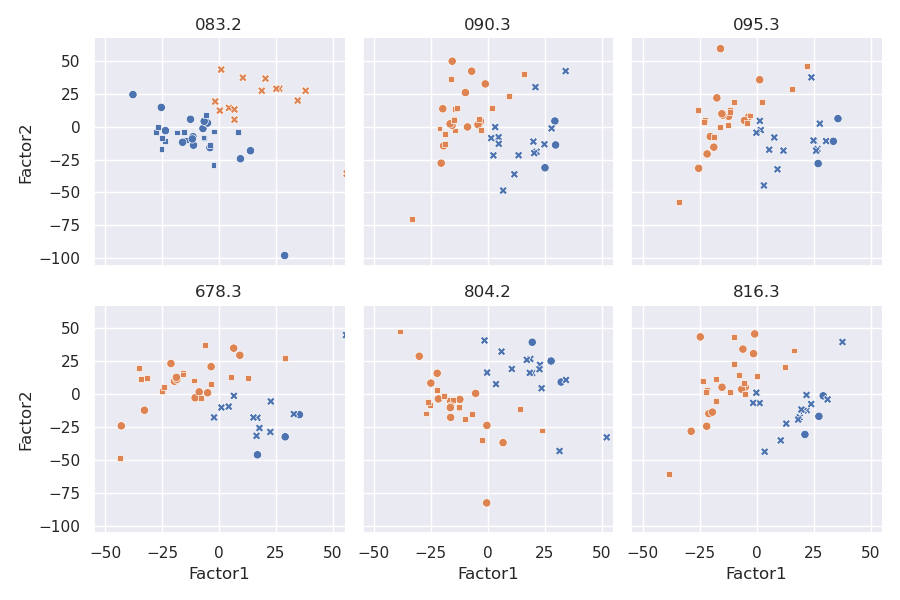

In [7]:
g = (
    sns.FacetGrid(
        df_pls.replace({"mem_mic_level": {0: "low", 1: "high"}}), 
        col="strain_left", 
        col_wrap=3
    )
    .map_dataframe(
        sns.scatterplot,
        x="Factor1",
        y="Factor2",
        style="condition", 
        hue="mem_mic_level",
    )
    .set(xlim=(-55, 55))
    .set_titles(col_template="{col_name}")
)

We calculate the accuracy scores for each model:

In [8]:
scores = {}
for strain, model in models.items():
    data = df_norm_rot.query("strain == @strain")
    x = data.drop(columns=meta_cols).to_numpy()
    y = data.mem_mic_level.to_numpy()
    y_pred = [1 if y > 0.5 else 0 for y in model.predict(x)]
    scores[strain] = accuracy_score(y, y_pred)

We convert the above dictionary to a dataframe:

In [9]:
df_accuracy = (
    pd.DataFrame
    .from_dict(scores, orient="index", columns=["accuracy"])
    .reset_index(names="strain_left")
)
df_accuracy

,strain_left,accuracy
0,083.2,0.666667
1,090.3,0.555556
2,095.3,0.555556
3,678.3,0.666667
4,804.2,0.666667
5,816.3,0.333333


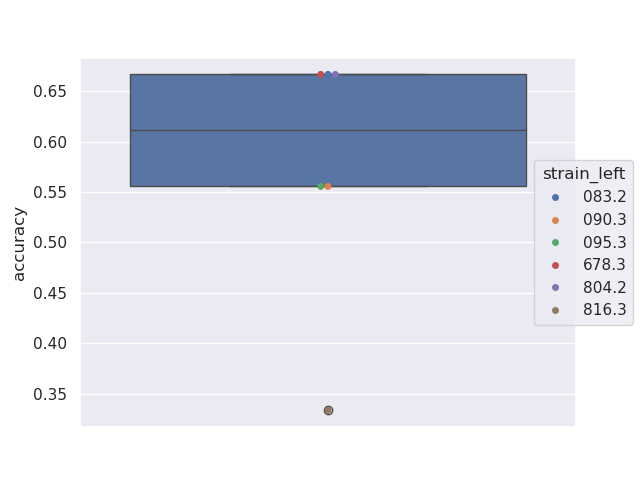

In [10]:
fig, ax = plt.subplots()
sns.boxplot(df_accuracy, y="accuracy")
sns.swarmplot(df_accuracy, y="accuracy", hue="strain_left")
sns.move_legend(ax, loc="center left", bbox_to_anchor=(0.9, 0.5))

**Tasks:** 
- can you determine what the top features have in common for these model?
- which features are in common between models?
- try to fit the other antibiotic